In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [2]:
# Carregando e Formatando dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATASETS/IbovespaHist.csv")
df["Data"] = pd.to_datetime(df["Data"],format="%d.%m.%Y")
df.set_index(df['Data'],inplace=True)
df = df.reindex(index=df.index[::-1])
df.drop("Data",axis= 1,inplace=True)
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2012-10-24,57.161,57.686,57.986,57.159,"2,93M","-0,92%"
2012-10-25,57.837,57.161,58.274,57.161,"3,15M","1,18%"
2012-10-26,57.277,57.833,57.833,57.061,"3,00M","-0,97%"
2012-10-29,57.177,57.267,57.267,56.581,"1,71M","-0,17%"
2012-10-30,57.684,57.178,57.764,57.178,"1,61M","0,89%"


Text(0.5, 1.0, 'Cotação de Fechamento do IBOV')

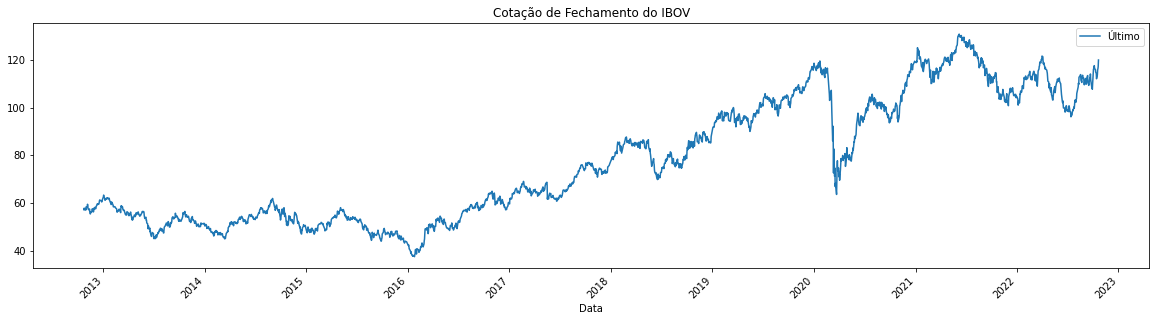

In [3]:
# Analisando valorização do indice
plt.figure(figsize=(20,5))
df["Último"].plot()
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.title("Cotação de Fechamento do IBOV")

In [4]:
df["Var"] = df["Var%"].str.replace(",", '.').str.replace("%","").astype("float32")
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Var
Data,,,,,,,
2012-10-24,57.161,57.686,57.986,57.159,"2,93M","-0,92%",-0.92
2012-10-25,57.837,57.161,58.274,57.161,"3,15M","1,18%",1.18
2012-10-26,57.277,57.833,57.833,57.061,"3,00M","-0,97%",-0.97
2012-10-29,57.177,57.267,57.267,56.581,"1,71M","-0,17%",-0.17
2012-10-30,57.684,57.178,57.764,57.178,"1,61M","0,89%",0.89


Média de fechamento:  0.042257283
Desvio Padrão de fechamento:  1.5832322


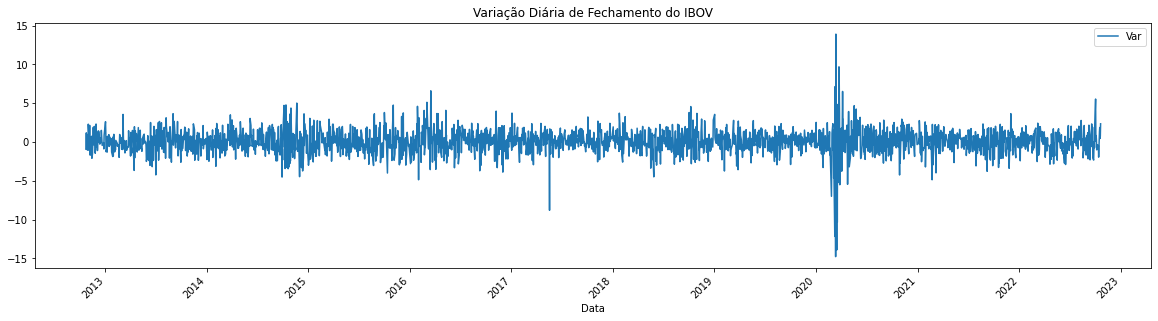

In [5]:
# Analisando comportamento do indice
plt.figure(figsize=(20,5))
df["Var"].plot()
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.title("Variação Diária de Fechamento do IBOV")

print("Média de fechamento: ",df.Var.mean())
print("Desvio Padrão de fechamento: ", df.Var.std())

In [6]:
#Normalizando dataset para evitar que valores grandes possuam peso maior
df_fech = df[["Último"]]
scaler = StandardScaler()
df_normal = scaler.fit_transform(df_fech)
df_normal

array([[-0.79823077],
       [-0.7717981 ],
       [-0.79369499],
       ...,
       [ 1.51318092],
       [ 1.54825504],
       [ 1.65609719]])

In [7]:
# Separando em dados de treino e teste, sem misturar os dados
train, test = train_test_split(df_normal,shuffle=False,test_size=0.3)

In [8]:
def create_df(df,steps):
  dataX,dataY=[],[]
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps),0]
    dataX.append(a)
    dataY.append(df[i + steps,0])
  return np.array(dataX), np.array(dataY)


In [9]:
steps = 10
X_train,y_train = create_df(train,steps)
X_test,y_test = create_df(test,steps)


In [10]:
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)


(731, 10)
(731,)
(1719, 10)
(1719,)


In [11]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [12]:
# Montando modelo
model = Sequential()
model.add(LSTM(35,return_sequences=True,input_shape=(steps,1)))
model.add(LSTM(35,return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.15))
model.add(Dense(1))

In [13]:
model.compile(optimizer="adam",loss = "mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 10, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [14]:
# treinamento
val = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100,batch_size=10,verbose=2)

Epoch 1/100
172/172 - 11s - loss: 0.0565 - val_loss: 0.0951 - 11s/epoch - 65ms/step
Epoch 2/100
172/172 - 3s - loss: 0.0131 - val_loss: 0.0559 - 3s/epoch - 16ms/step
Epoch 3/100
172/172 - 3s - loss: 0.0109 - val_loss: 0.0588 - 3s/epoch - 16ms/step
Epoch 4/100
172/172 - 3s - loss: 0.0102 - val_loss: 0.0391 - 3s/epoch - 16ms/step
Epoch 5/100
172/172 - 4s - loss: 0.0102 - val_loss: 0.0263 - 4s/epoch - 22ms/step
Epoch 6/100
172/172 - 3s - loss: 0.0097 - val_loss: 0.0494 - 3s/epoch - 19ms/step
Epoch 7/100
172/172 - 3s - loss: 0.0107 - val_loss: 0.0377 - 3s/epoch - 16ms/step
Epoch 8/100
172/172 - 3s - loss: 0.0094 - val_loss: 0.0501 - 3s/epoch - 16ms/step
Epoch 9/100
172/172 - 3s - loss: 0.0089 - val_loss: 0.0574 - 3s/epoch - 16ms/step
Epoch 10/100
172/172 - 3s - loss: 0.0087 - val_loss: 0.0288 - 3s/epoch - 16ms/step
Epoch 11/100
172/172 - 3s - loss: 0.0083 - val_loss: 0.0217 - 3s/epoch - 16ms/step
Epoch 12/100
172/172 - 3s - loss: 0.0087 - val_loss: 0.0264 - 3s/epoch - 16ms/step
Epoch 13/10

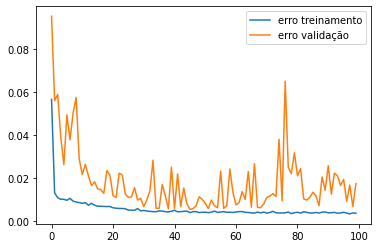

In [15]:
plt.plot(val.history["loss"], label = "erro treinamento")
plt.plot(val.history["val_loss"], label = "erro validação")
plt.legend()

In [16]:
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

23/23 [==============================] - 2s 6ms/step


array([[107.849846],
       [106.081535],
       [107.08229 ],
       [105.37079 ],
       [105.187256],
       [105.39816 ],
       [105.099464],
       [104.83098 ],
       [106.15642 ],
       [106.90601 ],
       [106.7661  ],
       [105.76603 ],
       [106.408936],
       [106.66391 ],
       [106.68605 ],
       [107.28759 ],
       [107.23245 ],
       [108.394104],
       [108.48163 ],
       [109.03116 ],
       [108.85592 ],
       [108.730034],
       [108.96213 ],
       [109.871414],
       [110.06674 ],
       [109.66795 ],
       [110.31004 ],
       [111.4323  ],
       [111.97629 ],
       [112.068016],
       [112.68405 ],
       [113.572815],
       [113.06448 ],
       [112.65789 ],
       [114.70106 ],
       [113.7328  ],
       [113.65876 ],
       [113.37558 ],
       [113.107285],
       [112.90306 ],
       [112.57165 ],
       [113.88032 ],
       [113.85111 ],
       [113.1939  ],
       [113.49693 ],
       [114.58056 ],
       [114.734535],
       [113.5

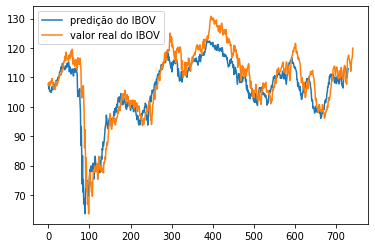

In [17]:
plt.plot(prev,label="predição do IBOV")
plt.plot(scaler.inverse_transform(test),label="valor real do IBOV")
plt.legend()
plt.show()

119.929